In [1]:
import seaborn as sns
from Bio.Phylo._utils import draw
from Bio.Phylo.BaseTree import Clade as BioClade
from src.distribution_analysis.process_tree import get_observed_nodes, get_clade_split_df
from collections import Counter
from src.datasets.load_trees import load_trees, TreeDataset
from src.utils.tree_utils import get_taxa_names, to_pruned_newick
from scipy.stats import pearsonr
import matplotlib.colors as mcolors

In [2]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [3]:
DATA_SET = TreeDataset.YULE_10
DATA_SET_NAME = DATA_SET.value

In [4]:
trees = load_trees(DATA_SET, max_files=1)

1it [00:04,  4.98s/it]


In [5]:
taxa_names = get_taxa_names(trees[0])
observed_nodes, observed_clade_splits = get_observed_nodes(trees, taxa_names)
df_clade_splits = get_clade_split_df(observed_clade_splits)

35001it [00:01, 27208.70it/s]
100%|██████████| 315009/315009 [00:00<00:00, 1423003.94it/s]


In [6]:
tree_newicks = [
    to_pruned_newick(tree) for tree in trees
]
most_common_newick = Counter(tree_newicks).most_common(1)[0][0]
most_common_tree = next(tree for tree in trees if to_pruned_newick(tree) == most_common_newick)

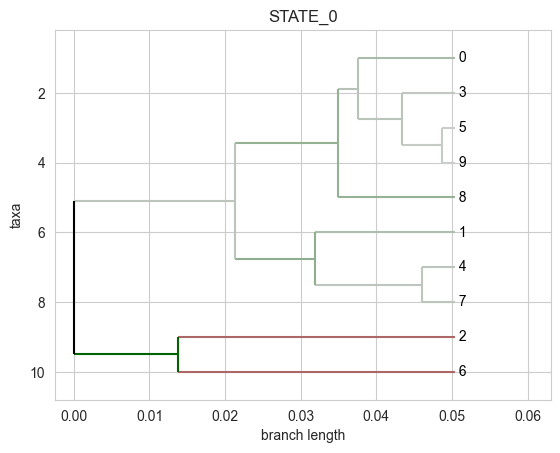

In [23]:
draw(most_common_tree)

In [18]:
def _map_bitstrings_to_bio_clades(
    bio_clade: BioClade,
    bitstring_to_left_clade: dict[str, BioClade],
    bitstring_to_right_clade: dict[str, BioClade],
) -> int:
    if bio_clade.is_terminal():
        if not bio_clade.name:
            raise ValueError("BioClade has no name.")

        clade_bitstring = 1
        clade_bitstring = clade_bitstring << taxa_names.index(bio_clade.name)
        
        return clade_bitstring

    left_clade = _map_bitstrings_to_bio_clades(
        bio_clade.clades[0],
        bitstring_to_left_clade,
        bitstring_to_right_clade,
    )
    right_clade = _map_bitstrings_to_bio_clades(
        bio_clade.clades[1],
        bitstring_to_left_clade,
        bitstring_to_right_clade,
    )

    clade_bitstring = left_clade | right_clade
    
    bitstring_to_left_clade["{0:010b}||{1:010b}".format(left_clade, right_clade)] = bio_clade.clades[0]
    bitstring_to_right_clade["{0:010b}||{1:010b}".format(left_clade, right_clade)] = bio_clade.clades[1]

    print()

    return clade_bitstring

bitstring_to_left_clade: dict[str, BioClade] = {}
bitstring_to_right_clade: dict[str, BioClade] = {}
_map_bitstrings_to_bio_clades(most_common_tree.root, bitstring_to_left_clade, bitstring_to_right_clade)

1023

In [19]:
def to_color(value):
    cmap = mcolors.LinearSegmentedColormap.from_list('red_black_green', ['darkred', '#d1d1d1', 'darkgreen'])
    norm = mcolors.Normalize(vmin=-1, vmax=1)    
    rgba_color = cmap(norm(value))

    return mcolors.rgb2hex(rgba_color)

In [20]:
from typing import Literal
from src.distribution_analysis.clade import ObservedCladeSplit


def draw_clade_correlations(
    ref_clade_split: str, branch: Literal["left_branch", "right_branch"]
):
    df_relevant_splits = df_clade_splits[
        df_clade_splits["newick_tree"] == to_pruned_newick(most_common_tree)
    ]

    ref_branch_lengths_per_tree = dict(
        zip(
            df_relevant_splits[df_relevant_splits["clade_split"] == ref_clade_split][
                "tree_index"
            ],
            df_relevant_splits[df_relevant_splits["clade_split"] == ref_clade_split][
                branch
            ],
        )
    )
    ref_branch_lengths = [
        ref_branch_lengths_per_tree[tree_index]
        for tree_index in sorted(ref_branch_lengths_per_tree.keys())
    ]

    for split in df_relevant_splits["clade_split"].unique():
        # add correlations with left branch

        query_branch_lengths_per_tree = dict(
            zip(
                df_relevant_splits[df_relevant_splits["clade_split"] == split][
                    "tree_index"
                ],
                df_relevant_splits[df_relevant_splits["clade_split"] == split][
                    "left_branch"
                ],
            )
        )
        query_branch_lengths = [
            query_branch_lengths_per_tree[tree_index]
            for tree_index in sorted(query_branch_lengths_per_tree.keys())
        ]

        correlation = pearsonr(ref_branch_lengths, query_branch_lengths)[0]
        if split in bitstring_to_left_clade:
            bitstring_to_left_clade[split].color = to_color(correlation)

        # add correlations with right branch

        query_branch_lengths_per_tree = dict(   
            zip(
                df_relevant_splits[df_relevant_splits["clade_split"] == split][
                    "tree_index"
                ],
                df_relevant_splits[df_relevant_splits["clade_split"] == split][
                    "right_branch"
                ],
            )
        )
        query_branch_lengths = [
            query_branch_lengths_per_tree[tree_index]
            for tree_index in sorted(query_branch_lengths_per_tree.keys())
        ]

        correlation = pearsonr(ref_branch_lengths, query_branch_lengths)[0]
        if split in bitstring_to_right_clade:
            bitstring_to_right_clade[split].color = to_color(correlation)

    draw(most_common_tree)

In [21]:
df_clade_splits[df_clade_splits["newick_tree"] == to_pruned_newick(most_common_tree)][
    "clade_split"
].unique()

array(['0000000100||0000001000', '0000000010||0000001100',
       '0000000001||0000001110', '0000001111||0000010000',
       '0001000000||0010000000', '0000100000||0011000000',
       '0000011111||0011100000', '0100000000||1000000000',
       '0011111111||1100000000'], dtype=object)

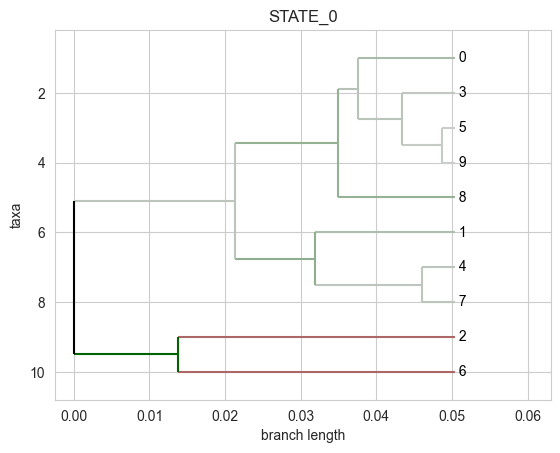

In [32]:
draw_clade_correlations("0011111111||1100000000", "right_branch")